# Next N-words prediction
    -Kashish

<h3>Problem Statement</h3>
Given a sequence of words, we need to build a deep learning model that can predict next n-probable words with high accuracy.

<h3>Real World Objectives: </h3>
<li>Multi-class probability estimation</li>
<li>Minimize multi-class probability estimation error</li>


# Import necessary libraries

In [1]:
from pandas import read_csv
# import re 
from keras.preprocessing.text import Tokenizer
from pandas import DataFrame
from seaborn import lineplot
from matplotlib.pyplot import grid,xlabel,ylabel

# Data Collection and Exploratory Data Analysis
The dataset is taken from kaggle and can be downloaded using the following link: https://www.kaggle.com/code/ysthehurricane/next-word-prediction-bi-lstm-tutorial-easy-way/data

In [2]:
raw_data=read_csv("../next_n_word_prediction/medium_data.csv")
raw_data.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


In [3]:
print(r'No. of records :',raw_data.shape[0])

No. of records : 6508


In [4]:
raw_data['title']= raw_data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
raw_data['title']= raw_data['title'].apply(lambda x: x.replace('\u200a',' '))

In [5]:
raw_data['title'].describe()

count                    6508
unique                   6504
top       Lost in translation
freq                        2
Name: title, dtype: object

In [6]:
print(r'Number of lines in dataset : {}'.format(len(raw_data)))
tokenizer=Tokenizer(oov_token='OOV')
tokenizer.fit_on_texts(raw_data['title'])
print(r"Number of unique words in dataset :{}".format(len(tokenizer.word_index)))
tokenized_data=tokenizer.texts_to_sequences(raw_data['title'])
sequence_lengths= [len(sequence) for sequence in tokenized_data]
print("Max length of a sequence : {} \nMin length of a sequence : {}".format(max(sequence_lengths),min(sequence_lengths)))

Number of lines in dataset : 6508
Number of unique words in dataset :8237
Max length of a sequence : 40 
Min length of a sequence : 1


In [7]:
plot_df= DataFrame({'n_lines':sequence_lengths})
plot_df= plot_df.n_lines.value_counts().reset_index()

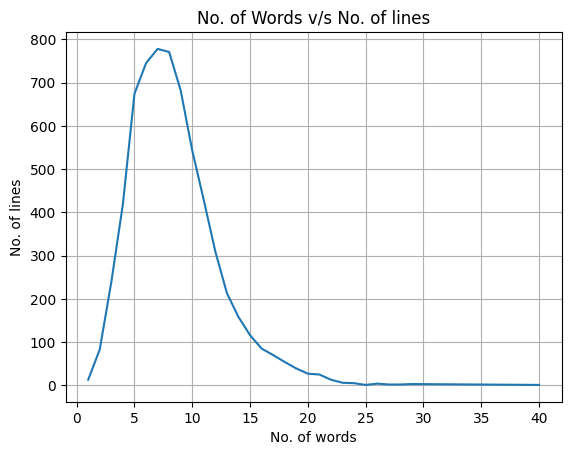

In [8]:
lineplot(data=plot_df,x=plot_df.iloc[:,0],y=plot_df.iloc[:,1]).set(title= "No. of Words v/s No. of lines")
xlabel("No. of words")
ylabel("No. of lines")
grid(True)

# Data Processing
The data is processed so as to feed to model for training.
<li>Create n-gram sequences</li>
<li>Padding the data with zeros</li>

In [9]:
train_seq=[sequence[:i] for sequence in tokenized_data for i in range(2,len(sequence)+1)]

In [10]:
from keras.utils import pad_sequences
padded_seq= pad_sequences(train_seq)

In [11]:
x_train,y_train=padded_seq[:,:-1],padded_seq[:,-1]

In [12]:
x_train.shape

(48461, 39)

# Defining and Training the Model
Setting model parameters and layers, using a seqential model

In [13]:
#setting the parameters for model with Bidirectional LSTM and LSTM layers
vocab_size=len(tokenizer.word_index)+1
wv_dims=100
input_length= x_train.shape[1]
dropout_rate=0.2
lstm_units_count=128
regularization_rate=0.001
epochs=50

In [14]:
from keras import Sequential
from keras.layers import Embedding,Bidirectional,LSTM,Dropout,Dense,Flatten
from keras.regularizers import L2
from keras.callbacks import ModelCheckpoint

In [15]:
#deining the model 
model=Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=wv_dims,input_length=input_length))
model.add(Bidirectional(layer=LSTM(units=lstm_units_count,return_sequences=True,dropout=dropout_rate)))
model.add(Dropout(rate=dropout_rate))
model.add(LSTM(units=lstm_units_count))
# model.add(Flatten())
model.add(Dense(units=2*lstm_units_count,activation='relu',activity_regularizer=L2(regularization_rate)))
model.add(Dense(units=vocab_size,activation='softmax'))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
checkpoint=ModelCheckpoint(filepath='../next_n_word_prediction/acModelBidirecLSTM.best.hdf5',monitor='val_accuracy',save_best_only=True,mode='max')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 39, 100)           823800    
                                                                 
 bidirectional (Bidirectiona  (None, 39, 256)          234496    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 39, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dense_1 (Dense)             (None, 8238)              2117166   
                                                        

In [17]:
#training the model
history= model.fit(x=x_train,y=y_train,batch_size=128,epochs=epochs,verbose='auto',callbacks=[checkpoint],use_multiprocessing=False)

Epoch 1/50
379/379 [==============================] - 154s 407ms/step - loss: 6.6100 - accuracy: 0.0899
Epoch 2/50
379/379 [==============================] - 153s 405ms/step - loss: 6.3065 - accuracy: 0.1158
Epoch 3/50
379/379 [==============================] - 158s 416ms/step - loss: 6.0439 - accuracy: 0.1347
Epoch 4/50
379/379 [==============================] - 155s 408ms/step - loss: 5.8347 - accuracy: 0.1450
Epoch 5/50
379/379 [==============================] - 158s 417ms/step - loss: 5.6604 - accuracy: 0.1573
Epoch 6/50
292/379 [======================>.......] - ETA: 37s - loss: 5.5024 - accuracy: 0.1687

KeyboardInterrupt: 